In [22]:
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

# data frame and arrays
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Training and test data module
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Oversampling method
from imblearn.over_sampling import SMOTE

# Other
from sklearn.preprocessing import LabelEncoder, label_binarize
from collections import Counter
import itertools
import random
from IPython.display import Image

# Feature importance
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [4]:
data = pd.read_csv('hospdat.csv')
# delete columns 'Unnamed: 0', 'INFO' and 'Age'
data.drop(['Unnamed: 0', 'INFO', 'Age', 'ID', 'Last_followup'], axis=1, inplace=True)
# rename the outcome feature, 'Cause_of_redo' to 'Type_of_condition' and 'GROUP' to 'Type_of_implant'
data = data.rename(columns={'Cause_of_redo': 'Type_of_condition', 'GROUP':'Type_of_implant'})

data.replace(to_replace=['NHIP XOANG', 'RUNG NHI'],
           value=['Sinus arrhythmia', 'Atrial fibrillation'], 
           inplace=True)

In [5]:
def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            'cannot handle data conversion of type: {} to {}'.format(
                type(data), to))
    else:
        return converted


def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]


def replace_nan_with_value(x, y, value):
    x = np.array([v if v == v and v is not None else value for v in x])  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

def _display_roc_plot(xlim, ylim, legend):
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC-AUC Curves', fontsize=25, loc='right')
    if legend:
        plt.legend(loc=legend, fontsize=13)
    plt.show()


def _draw_estimated_optimal_threshold_mark(fpr, tpr, thresholds, color, ms, fmt, ax):
    annotation_offset = (-.027, .03)
    a = np.zeros((len(fpr), 2))
    a[:, 0] = fpr
    a[:, 1] = tpr
    dist = lambda row: row[0]**2 + (1 - row[1])**2
    amin = np.apply_along_axis(dist, 1, a).argmin()
    plt.plot(fpr[amin], tpr[amin], color=color, marker='o', ms=ms)
    ax.annotate("{th:{fmt}}".format(th=thresholds[amin], fmt=fmt),
                xy=(fpr[amin], tpr[amin]), color=color,
                xytext=(fpr[amin]+annotation_offset[0],
                        tpr[amin]+annotation_offset[1]),
                size=14, weight='bold')
    return thresholds[amin]


def _plot_macro_roc(fpr, tpr, n, lw, fmt, ax):
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    auc_macro = auc(fpr_macro, tpr_macro)
    label = 'ROC curve: macro (AUC = {auc:{fmt}})'.format(auc=auc_macro, fmt=fmt)
    ax.plot(fpr_macro,
            tpr_macro,
            label=label,
            color='navy',
            ls=':',
            lw=lw)


def _binary_roc_graph(y_true, y_pred, eoptimal, class_label, color, lw, ls, ms, fmt, ax):
    y_true = convert(y_true, 'array')
    y_pred = convert(y_pred, 'array')
    if y_pred.shape != y_true.shape:
        raise ValueError('y_true and y_pred must have the same shape')
    elif len(y_pred.shape) == 1:
        y_t = y_true
        y_p = y_pred
    else:
        y_t = [np.argmax(x) for x in y_true]
        y_p = [x[1] for x in y_pred]
    fpr, tpr, th = roc_curve(y_t, y_p)
    auc_score = auc(fpr, tpr)
    if class_label is not None:
        class_label = ': ' + class_label
    else:
        class_label = ''
    label = 'ROC curve{class_label} (AUC = {auc:{fmt}}'.format(class_label=class_label, auc=auc_score, fmt=fmt)
    if eoptimal:
        eopt = _draw_estimated_optimal_threshold_mark(fpr, tpr, th, color, ms, fmt, ax)
        label += ', eOpT = {th:{fmt}})'.format(th=eopt, fmt=fmt)
    else:
        eopt = None
        label += ')'
    ax.plot(fpr,
            tpr,
            color=color,
            lw=lw,
            ls=ls,
            label=label)
    return {'fpr': fpr, 'tpr': tpr, 'thresholds': th,
            'auc': auc_score, 'eopt': eopt}


def roc_plot(y_true,
              y_pred,
              micro=True,
              macro=True,
              eopt=True,
              class_names=None,
              colors=None,
              ax=None,
              figsize=None,
              xlim=(0.,1.),
              ylim=(0.,1.02),
              lw=2,
              ls='-',
              ms=10,
              fmt='.2f',
              legend='best',
              plot=True
              ):
    all_fpr = list()
    all_tpr = list()
    y_true = convert(y_true, 'array')
    y_pred = convert(y_pred, 'array')
    if y_pred.shape != y_true.shape:
        raise ValueError('y_true and y_pred must have the same shape')
    if class_names is not None:
        if not isinstance(class_names, str):
            class_names = convert(class_names, 'list')
        else:
            class_names = [class_names]
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    colors = colors or ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
    output_dict = dict()
    if len(y_pred.shape) == 1 or y_pred.shape[1] <= 2:
        class_label = class_names[-1] if class_names is not None else None
        d = _binary_roc_graph(y_true, y_pred, eoptimal=eopt,
                              class_label=class_label, color=colors[-1],
                              lw=lw, ls=ls, ms=ms, fmt=fmt, ax=ax)
        class_label = class_label or '0'
        output_dict[class_label] = {'auc': d['auc'],
                                    'eopt': d['eopt']}
    else:
        n = y_pred.shape[1]
        if class_names is not None:
            if not isinstance(class_names, list):
                raise ValueError('class_names must be a list of items in multi-class classification.')
            if len(class_names) != n:
                raise ValueError('Number of class names does not match input data size.')
        for i in range(0, n):
            class_label = class_names[i] if class_names is not None else str(i)
            d = _binary_roc_graph(y_true[:, i],
                                  y_pred[:, i],
                                  eoptimal=eopt,
                                  color=colors[i % len(colors)],
                                  class_label=class_label,
                                  lw=lw, ls=ls, ms=ms, fmt=fmt, ax=ax)
            all_fpr.append(d['fpr'])
            all_tpr.append(d['tpr'])
            output_dict[class_label] = {'auc': d['auc'],
                                        'eopt': d['eopt']}
        if micro:
            _binary_roc_graph(y_true.ravel(),
                              y_pred.ravel(),
                              eoptimal=False,
                              ls=':',
                              color='deeppink',
                              class_label='micro',
                              lw=lw, ms=ms, fmt=fmt, ax=ax)
        if macro:
            _plot_macro_roc(all_fpr, all_tpr, n, lw, fmt, ax)
    if plot:
        _display_roc_plot(xlim=xlim, ylim=ylim, legend=legend)
    output_dict['ax'] = ax
    return output_dict

In [28]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontweight='bold', fontsize=13)
    ax.set_yticklabels(row_labels, fontweight='bold', fontsize=13)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position('top')


    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, fontsize=15)
            texts.append(text)

    return texts

In [67]:
plt.rcParams['axes.facecolor'] = 'aliceblue'

y = LabelEncoder().fit_transform(data["Type_of_condition"])
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=5, max_depth=4, random_state=0))

colors = ['darkslateblue', 'cornflowerblue', 'dodgerblue']

target_names = ["MR", "MS", "None"]

oversample = SMOTE()

random.seed(112)


def rf_function(X, 
                y = y, 
                classifier = classifier,
                ):
    
    X = X.apply(LabelEncoder().fit_transform)
    
    if oversamp:
        X, y = oversample.fit_resample(X, y)
        y = label_binarize(y, classes=[0,1,2])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    else: 
        y = label_binarize(y, classes=[0,1,2])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    
    full_model = classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test)

    s = 0

    for i in range(y_test.shape[0]):
        if y_test[i,:].argmax() == y_pred[i,:].argmax():
            s += 1
    label1 = print("\n",'\033[36m' + '\033[1m' + 'Output 1:',  '\033[0m' + 'Correct predictions based on test data')
    predictions = print('    {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))
    label2 = print("\n", '\033[36m' + '\033[1m' + 'Output 2:',  '\033[0m' + "ROC-AUC curves for each class")
    rplot = roc_plot(y_test, y_pred, class_names = target_names, figsize=(10,10), colors=colors)
    
    fig, ax = plt.subplots()

    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    CM = confusion_matrix(y_true, y_pred)

    im, cbar = heatmap(CM, target_names, target_names, ax=ax,
                   cmap="Blues", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x}")
    
    label3 = print("\n", '\033[36m' + '\033[1m' + 'Output 3:', '\033[0m' + "3x3 Confusion matrix")
    fig = plt.figure(figsize=(8, 6))
    plt.show()
    
    label4 = print('\n', '\033[36m' + '\033[1m' + 'Output 4:', '\033[0m' + "Performance metrics")
    metrics = print(classification_report(y_true, y_pred, target_names=target_names))
        
    return {'predictions': predictions, 'label2': label2, 'roc_plot': rplot, 'label3': label3, 'labels4':label4, 'metrics': metrics}


 Output 1: Correct predictions based on test data
    17/72 (23.61%)

 Output 2: ROC-AUC curves for each class


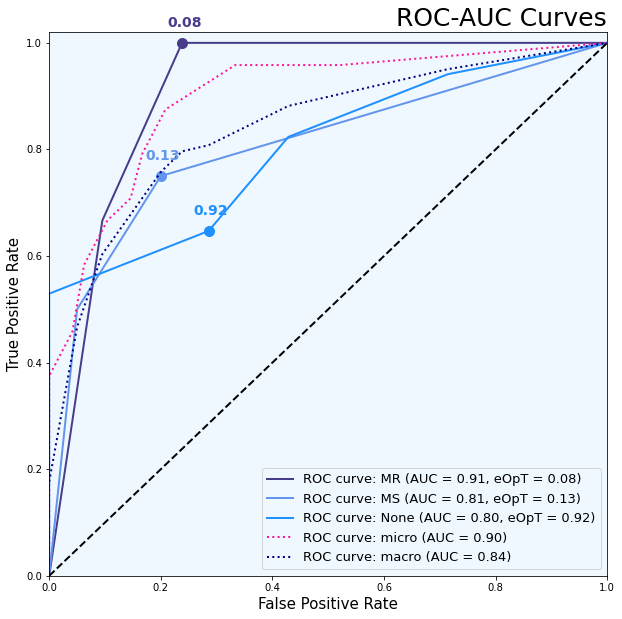


 Output 3: 3x3 Confusion matrix


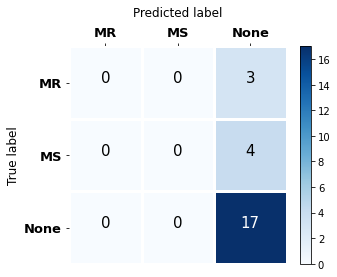

<Figure size 576x432 with 0 Axes>


 Output 4: Performance metrics
              precision    recall  f1-score   support

          MR       0.00      0.00      0.00         3
          MS       0.00      0.00      0.00         4
        None       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.24      0.33      0.28        24
weighted avg       0.50      0.71      0.59        24



{'predictions': None,
 'label2': None,
 'roc_plot': {'MR': {'auc': 0.9126984126984127, 'eopt': 0.07908496732026143},
  'MS': {'auc': 0.8062500000000001, 'eopt': 0.13295740207504914},
  'None': {'auc': 0.8025210084033614, 'eopt': 0.9209150326797385},
  'ax': <matplotlib.axes._subplots.AxesSubplot at 0x1264ad8b0>},
 'label3': None,
 'labels4': None,
 'metrics': None}

In [68]:
#X = data.drop(columns=['Type_of_condition'], axis=1)

X = data[['Age_group', 'Type_of_implant']]                        # predictors

oversamp = False

rf_function(X = X)

In [66]:
print('\033[91m' + '\033[1m' + 'Hello')

Hello
